In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import scipy.sparse as sparse
import implicit

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
# pip install implicit

In [104]:
train_data=pd.read_csv("basket_data_by_date_train.csv")
test_data=pd.read_csv("basket_data_by_date_test.csv")

In [105]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [106]:
train_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,540254.879225,3.487700,3.732165,15577.606525,11.097411
std,2380.444952,2.611766,5.711630,1730.347123,13.298301
min,536365.000000,1.000000,0.100000,12347.000000,0.140000
25%,538093.000000,1.000000,1.650000,14224.000000,3.300000
50%,540373.000000,2.000000,2.950000,15570.000000,7.950000
75%,542360.000000,6.000000,4.650000,17220.000000,15.800000
max,544398.000000,10.000000,295.000000,18283.000000,527.700000


- **Quantity:** On average, each transaction involves buying around 3 to 4 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.1`, while the most expensive one is `$295.00`.
- **CustomerID:** The lowest customer number is 12347, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.14`., while the largest one is `$527.7`.

In [107]:
train_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [108]:
train_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [109]:
test_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,545209.692000,3.672100,3.971454,15433.082900,11.840678
std,492.638789,2.639788,6.777596,1616.660727,13.086198
min,544398.000000,1.000000,0.160000,12352.000000,0.190000
25%,544795.000000,2.000000,1.650000,14227.000000,3.750000
50%,545181.000000,3.000000,2.950000,15358.000000,9.900000
75%,545664.000000,6.000000,4.950000,16931.000000,16.500000
max,546084.000000,10.000000,195.000000,18283.000000,290.000000


For the test data:
- **Quantity:** On average, each transaction involves buying around 3.67 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.10`, while the most expensive one is `$195.00`.
- **CustomerID:** The lowest customer number is 12352, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.19` , while the largest one is `$290.00`.

In [110]:
test_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [111]:
#removing any rows containing missing values (NaN)
test_data = test_data.dropna()

In [112]:
#checking null values in test dataset
test_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [113]:
# Checking for duplicate rows
train_data.duplicated().sum()

797

In [114]:
# Checking for duplicate rows
test_data.duplicated().sum()

150

In [115]:
# Removing duplicate rows
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [116]:
#Lowering all text
train_data=train_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_data=test_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [117]:
format_string = "%d/%m/%Y %H:%M"
# Converting 'Date' column to datetime objects
train_data['Date'] = pd.to_datetime(train_data['Date'], format=format_string)
test_data['Date'] = pd.to_datetime(test_data['Date'], format=format_string)

In [118]:
#Merging to plot graphs
dataset = pd.concat([train_data, test_data])

In [119]:
item_count= dataset.groupby(["Itemname"]).count()
item_count

,BillNo,Quantity,Date,Price,CustomerID,cost
Itemname,,,,,,
10 colour spaceboy pen,5,5,5,5,5,5
12 coloured party balloons,11,11,11,11,11,11
12 daisy pegs in wood box,22,22,22,22,22,22
12 egg house painted wood,16,16,16,16,16,16
12 ivory rose peg place settings,19,19,19,19,19,19
...,...,...,...,...,...,...
zinc heart lattice t-light holder,7,7,7,7,7,7
zinc heart lattice tray oval,2,2,2,2,2,2
zinc metal heart decoration,45,45,45,45,45,45


Text(0.5, 1.0, 'Top 10 Popular Sold Items')

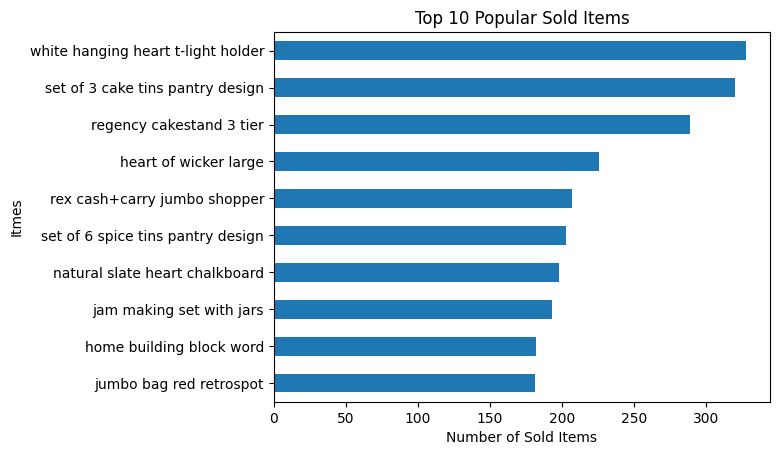

In [120]:
# Top 10 Popular Sold Items
df= dataset.groupby(["Itemname"])["Quantity"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Sold Items')
plt.title('Top 10 Popular Sold Items')

In [121]:
df = dataset.groupby("CustomerID")["CustomerID"].count()
df

CustomerID
12347.0     32
12350.0      2
12352.0     13
12356.0      1
12361.0      5
          ... 
18259.0      3
18260.0     16
18269.0      5
18280.0     10
18283.0    129
Name: CustomerID, Length: 1660, dtype: int64

In [122]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
df

CustomerID
14606.0    767
17841.0    764
12748.0    722
15311.0    619
15039.0    392
18118.0    344
14796.0    295
17850.0    282
14527.0    245
17811.0    244
Name: CustomerID, dtype: int64

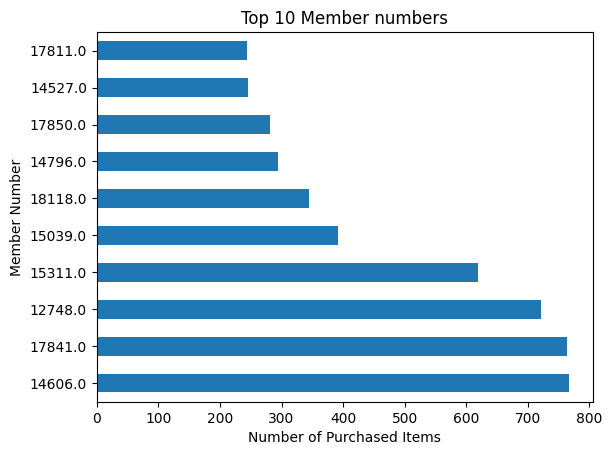

In [123]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
# Plot the top 10 member numbers
df.plot(kind="barh")
plt.ylabel('Member Number')
plt.xlabel('Number of Purchased Items')
plt.title('Top 10 Member numbers')
plt.show()

In [124]:
dataset[dataset['Quantity'] < 1]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


In [125]:
zero_price_count = len(dataset[dataset['cost'] == 0])
print("Number of rows where price is zero:", zero_price_count)
# Counting the number of rows where the price is negative
negative_price_count = len(dataset[dataset['cost'] < 0])
print("Number of rows where price is negative:", negative_price_count)

Number of rows where price is zero: 0
Number of rows where price is negative: 0


Month
2010-12    189586.78
Name: cost, dtype: float64
Month
2011-01    163000.93
2011-02    149459.02
2011-03     56291.37
Name: cost, dtype: float64


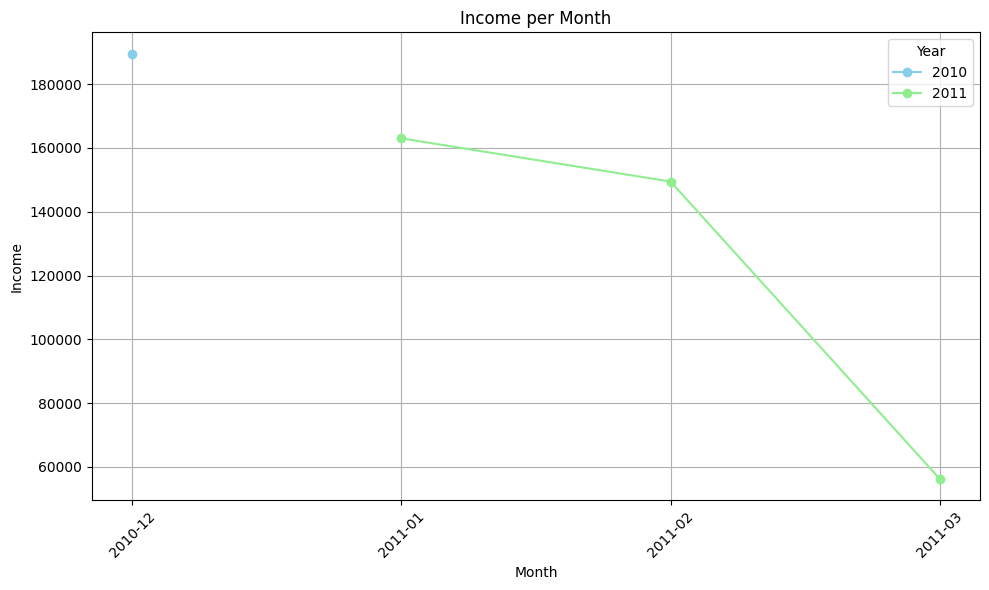

In [126]:
def plot_income_per_month(data, years, colors):
    plt.figure(figsize=(10, 6))

    for year, color in zip(years, colors):
        df_year = data[data['Date'].dt.year == year]
        df_year['Month'] = df_year['Date'].dt.strftime('%Y-%m')
        monthly_income = df_year.groupby('Month')['cost'].sum()
        print(monthly_income)
        plt.plot(monthly_income.index, monthly_income.values, marker='o', color=color, label=str(year))

    plt.title('Income per Month')
    plt.xlabel('Month')
    plt.ylabel('Income')
    plt.xticks(rotation=45)
    plt.legend(title='Year')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
years = [2010, 2011]
colors = ['skyblue', 'lightgreen']
plot_income_per_month(dataset, years, colors)

In [127]:
train_df=train_data.copy()
test_df = test_data.copy()

In [128]:
train_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(train_df)):
    customer_id = train_df.iloc[i]["CustomerID"]
    item_name = train_df.iloc[i]["Itemname"]
    temp = train_df.loc[(train_df["CustomerID"] == customer_id) & (train_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    train_rating_df = pd.concat([train_rating_df, pd.DataFrame([create_row])], ignore_index=True)

KeyboardInterrupt: 

In [ ]:
test_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(test_df)):
    customer_id = test_df.iloc[i]["CustomerID"]
    item_name = test_df.iloc[i]["Itemname"]
    temp = test_df.loc[(test_df["CustomerID"] == customer_id) & (test_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    test_rating_df = pd.concat([test_rating_df, pd.DataFrame([create_row])], ignore_index=True)

In [ ]:
#droping duplicates
train_rating = train_rating_df.drop_duplicates()
test_rating = test_rating_df.drop_duplicates()

In [ ]:
unique_customer_count = dataset['CustomerID'].unique()
unique_items_count = dataset['Itemname'].unique()

In [ ]:
print("Total customer count:", len(unique_customer_count))
print("Total items count:", len(unique_items_count))

In [ ]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='Itemname', columns='CustomerID', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)

In [ ]:
train_rating_piv_df

In [ ]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

In [ ]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='Itemname', columns='CustomerID', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)

similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

In [ ]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,userid]
    item_similarity = sim_rating.sort_values(by=itemname, ascending=False).loc[:, itemname].tolist()
    weighted_sum = np.dot(item_similarity, user_rating)
    weighted_sum /= np.sum(item_similarity)
    return weighted_sum

In [ ]:
#Evaulate performance on train data set
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

In [ ]:
#Evaulate performance on test data set
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

In [ ]:
# get the recommandations
def get_recommandation(item,n):
    if item not in similarity_matrix_test_df.columns:
        print("Item not found!")
        return None
    else:
        recommendations=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
        items = similarity_matrix_test_df.sort_values(by=item, ascending=False).index[1:]
        score = similarity_matrix_test_df.sort_values(by=item, ascending=False).loc[:, item].tolist()[1:]
        recommendations["predicted_item"]=items[:n]
        recommendations["similarity"]=score[:n]
        recommendations["Itemname"]=item
        return recommendations

In [ ]:
get_recommandation("jumbo shopper vintage red paisley",10)

In [ ]:
new_test_data = test_data.reset_index(drop=True)
result=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
for i in range(len(new_test_data)):
    temp=new_test_data.loc[i]
    item=temp["Itemname"]
    res = get_recommandation(item,1)
    result = pd.concat([result, pd.DataFrame(res)], ignore_index=True)

In [ ]:
result.sort_values(by='similarity', ascending=False)

In [ ]:
# Top 10 Popular Sold Items
df= result.groupby(["predicted_item"])["predicted_item"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')

In [ ]:
import time
import matplotlib.pyplot as plt

start_time_a = time.time()
new_test_data = test_data.reset_index(drop=True)
result_list = []

for i in range(len(new_test_data)):
    tmp = new_test_data.loc[i]
    item = tmp["Itemname"]
    res = get_recommandation(item, 1)
    result_list.append(pd.DataFrame(res))

result_new = pd.concat(result_list, ignore_index=True)

end_time_a = time.time()
cf_time = end_time_a - start_time_a
print("Time for generating recommendations using collaborative filtering: " + str(cf_time))

# Top 10 Popular Sold Items
df = result_new.groupby(["predicted_item"]).size().nlargest(10).sort_values(ascending=True)
df.plot(kind="barh")
plt.ylabel('Items')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')
plt.show()

In [ ]:
sorted_data = result.sort_values(by='similarity', ascending=False)
sorted_data[:10]

In [ ]:
get_recommandation("10 colour spaceboy pen",10)

In [ ]:
get_recommandation("travel card wallet union jack",10)

In [ ]:
get_recommandation("set of 6 spice tins pantry design", 10)

In [ ]:
get_recommandation("pink regency teacup and saucer",10)

In [ ]:
get_recommandation("jumbo bag red retrospot",10)

USER-BASED COLLABORATIVE FILTERING

In [ ]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='CustomerID', columns='Itemname', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)
train_rating_piv_df

In [ ]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

In [ ]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='CustomerID', columns='Itemname', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)
test_rating_piv_df

In [ ]:
similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

In [ ]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,itemname]
    user_similarity = sim_rating.sort_values(by=userid, ascending=False).loc[:, userid].tolist()
    weighted_sum = np.dot(user_similarity, user_rating)
    weighted_sum /= np.sum(user_similarity)
    return weighted_sum

In [ ]:
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

In [ ]:
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

### Matrix Factorization using ALS

In [ ]:
dataset_mf = dataset.copy()

In [ ]:
items_per_customer_df = (dataset_mf.groupby(["CustomerID"]).agg({"Itemname": "nunique"}).reset_index())

In [ ]:
items_per_customer_df.columns = ["CustomerID", "Count_item_cust"]
items_per_customer_df

In [ ]:
# Filtering Results
mask = items_per_customer_df["Count_item_cust"] >= 6
valid_customer = set(items_per_customer_df.loc[mask, "CustomerID"].tolist())
df_filter_cust = dataset[dataset["CustomerID"].isin(valid_customer)].copy()
billno_filter_cust = set(df_filter_cust["BillNo"].tolist())

In [ ]:
# Calculate count of unique customers per item
custs_per_item_df = dataset.groupby(["Itemname"]).agg({"CustomerID": "nunique"}).reset_index()
custs_per_item_df.columns = ["Itemname", "Count_cust_item"]

# Count the occurrences of each unique count of customers per item
counts_per_item = custs_per_item_df["Count_cust_item"].value_counts()
counts_per_item

In [ ]:
cust_in_item_threshold = 6

In [ ]:
# Filter Results
mask = custs_per_item_df["Count_cust_item"] >= cust_in_item_threshold
valid_billnos = set(custs_per_item_df.loc[mask, "Itemname"].tolist())


In [ ]:
# Filtering items based on valid stock codes
df_filter_item = dataset[dataset["Itemname"].isin(valid_billnos)].copy()
billnos_filter_item = set(df_filter_item["BillNo"].tolist())

# Finding the intersection of bill numbers
billnos_intersect = set.intersection(billnos_filter_item, billno_filter_cust)

# Printing the counts
print(f"No. of invoices after filtering by customer: {len(billno_filter_cust)}")
print(f"No. of invoices after filtering by item: {len(billnos_filter_item)}")
print(f"No. of invoices from intersection: {len(billnos_intersect)}")


In [ ]:
df_filter_cust_item = dataset[dataset["BillNo"].isin(billnos_intersect)].copy()

In [ ]:
df_filter_cust_item.info()

In [ ]:
unique_customers_filter = df_filter_cust_item["CustomerID"].unique()
customer_ids = dict(zip(unique_customers_filter, np.arange(unique_customers_filter.shape[0], dtype=np.int32)))

In [ ]:
unique_items_filter = df_filter_cust_item["Itemname"].unique()
item_ids_filter = dict(zip(unique_items_filter, np.arange(unique_items_filter.shape[0], dtype=np.int32)))

In [ ]:
df_filter_cust_item["customer_id"] = df_filter_cust_item["CustomerID"].apply(lambda i: customer_ids[i])
df_filter_cust_item["item_id"] = df_filter_cust_item["Itemname"].apply(lambda i: item_ids_filter[i])

In [ ]:
print(f"{len(customer_ids)}, {len(item_ids_filter)}")

In [ ]:
df_filter_cust_item.sort_values(by=["Itemname"], inplace=True)
df_filter_cust_item.head(10)

In [ ]:
df_cust_item_qty = df_filter_cust_item.groupby(["customer_id", "item_id"])["Quantity"].sum().reset_index()

In [ ]:
df_cust_item_qty.head()

In [ ]:
sparse_customer_item = sparse.csr_matrix((df_cust_item_qty["Quantity"].astype(float), (df_cust_item_qty["customer_id"], df_cust_item_qty["item_id"])))

In [137]:
model = implicit.als.AlternatingLeastSquares(num_threads=1)
model.fit(sparse_customer_item)

  0%|          | 0/15 [00:00<?, ?it/s]

In [101]:
item_vecs = model.item_factors
customer_vecs = model.user_factors

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
ref_item_id = df_filter_cust_item["item_id"].unique()

# Check the type of ref_item_id
print(type(ref_item_id))

<class 'numpy.ndarray'>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
similar_items, scores = model.similar_items(ref_item_id, N=10)
# Create a DataFrame from similar_items
df_similar_items = pd.DataFrame(similar_items)
# Add a column for the reference item ID
df_similar_items["Ref Item ID"] = ref_item_id
# Display the first few rows of the DataFrame
print(df_similar_items.head())

      0     1     2     3     4     5     6     7     8     9  Ref Item ID
0   787  1037   387  1682  2162  2514  1581  1517   479  1706          787
1   858  2340  1306  2594  2593  2314  2289  1043   862  1005          858
2   248  2608  1523  1981  2162  1037  1798  1067  1074  2415          248
3  2113   830  1350   692  1698  1970   634  1352   643  2251         2113
4  1215   841  1817   807  1744  2006  2301  1746  2397  1951         1215


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
df_item_rank = pd.melt(df_similar_items.rename(columns={"Ref Item ID": "Ref_Item_ID"}), id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Related Item ID")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
df_item_rank_sorted = df_item_rank.sort_values(by=["Related Item ID", "Item Rank"]).head(20)
df_item_rank_sorted

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Ref_Item_ID,Item Rank,Related Item ID
1254,0,0,0
9892,118,3,0
14265,116,5,0
16246,112,6,0
25494,3,9,0
1010,1,0,1
6247,2353,2,1
2528,2,0,2
10912,145,4,2
1923,3,0,3


In [50]:
df_score_rank = pd.DataFrame(scores).assign(Ref_Item_ID=ref_item_id).melt(id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Score").sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_score_rank

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Ref_Item_ID,Item Rank,Score
1254,0,0,1.000000
3873,0,1,0.456652
6492,0,2,0.454808
9111,0,3,0.441564
11730,0,4,0.440070
14349,0,5,0.436979
16968,0,6,0.434524
19587,0,7,0.386760
22206,0,8,0.385276
24825,0,9,0.379936


In [51]:
df_item_score = df_item_rank.merge(df_score_rank, how="inner", on=["Ref_Item_ID", "Item Rank"]).sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_item_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Ref_Item_ID,Item Rank,Related Item ID,Score
1,0,0,0,1.000000
3,0,1,2465,0.456652
5,0,2,118,0.454808
7,0,3,875,0.441564
9,0,4,2466,0.440070
11,0,5,2262,0.436979
13,0,6,2264,0.434524
15,0,7,2012,0.386760
17,0,8,3,0.385276
19,0,9,2263,0.379936


In [54]:
df_item_desc = df_filter_cust_item[["item_id", "Itemname"]].drop_duplicates(subset=["item_id"])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
df_similar_item_temp = df_item_score.merge(df_item_desc, how="left", left_on="Ref_Item_ID", right_on="item_id")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
df_similar_item_temp.drop(columns=["item_id"], inplace=True)
df_similar_item_temp.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [62]:
df_similar_item_temp.shape
df_similar_item_temp.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle
1,0,1,2465,0.456652,knitted union flag hot water bottle
2,0,2,118,0.454808,knitted union flag hot water bottle
3,0,3,875,0.441564,knitted union flag hot water bottle
4,0,4,2466,0.440070,knitted union flag hot water bottle


In [63]:
df_similar_item_final = df_similar_item_temp.merge(df_item_desc, how="left", left_on="Related Item ID", right_on="item_id")
df_similar_item_final.drop(columns=["item_id"], inplace=True)
df_similar_item_final.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
    "Related_BillNO",
]
df_similar_item_final.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO,Related_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle,knitted union flag hot water bottle
1,0,1,2465,0.456652,knitted union flag hot water bottle,lilac gauze butterfly lampshade
2,0,2,118,0.454808,knitted union flag hot water bottle,scottie dog hot water bottle
3,0,3,875,0.441564,knitted union flag hot water bottle,amethyst hoop earring floral leaf
4,0,4,2466,0.440070,knitted union flag hot water bottle,pink/purple circle curtain


In [66]:
df_cust_id_map = df_filter_cust_item[["CustomerID", "customer_id"]].drop_duplicates(subset="customer_id")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
df_cust_id_map.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CustomerID,customer_id
17683,17961.0,125
1696,14390.0,79
3291,14396.0,153
8501,17341.0,342
7415,14670.0,1263
22272,14669.0,744
6219,14085.0,249
27081,17889.0,852
26634,15498.0,338
4362,17211.0,188


In [77]:
CustomerID = 16714
cust_id = df_cust_id_map[df_cust_id_map["CustomerID"] == CustomerID]["customer_id"].item()
print(cust_id)

908


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
df_filter_cust_item[df_filter_cust_item["customer_id"] == cust_id]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,customer_id,item_id
29393,542231.0,12 coloured party balloons,10.0,2011-01-26 13:40:00,0.65,16714.0,6.50,908,858
29347,542231.0,3d hearts honeycomb paper garland,6.0,2011-01-26 13:40:00,2.95,16714.0,17.70,908,2349
29379,542231.0,alarm clock bakelike green,2.0,2011-01-26 13:40:00,3.75,16714.0,7.50,908,76
29348,542231.0,alarm clock bakelike red,2.0,2011-01-26 13:40:00,3.75,16714.0,7.50,908,103
29354,542231.0,alphabet hearts sticker sheet,3.0,2011-01-26 13:40:00,0.85,16714.0,2.55,908,1338
...,...,...,...,...,...,...,...,...,...
29389,542231.0,toast its - i love you,1.0,2011-01-26 13:40:00,1.25,16714.0,1.25,908,1230
29344,542231.0,vintage red kitchen cabinet,2.0,2011-01-26 13:40:00,125.00,16714.0,250.00,908,1920
29409,542231.0,white hanging heart t-light holder,6.0,2011-01-26 13:40:00,2.95,16714.0,17.70,908,2
29385,542231.0,wood stamp set thank you,4.0,2011-01-26 13:40:00,1.65,16714.0,6.60,908,1246


In [79]:
ids, scores = model.recommend(cust_id, sparse_customer_item[cust_id], N=20, filter_already_liked_items=False)
list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
df_recommendations = pd.DataFrame(
    {
        "BillNo": list_billno,
        "score": scores,
        "already_liked": np.in1d(ids, sparse_customer_item[cust_id].indices),
    }
)
df_recommendations

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,BillNo,score,already_liked
0,alarm clock bakelike green,1.113724,True
1,assorted colour bird ornament,1.040044,True
2,coffee mug apples design,1.030116,True
3,coffee mug pears design,1.020545,True
4,doormat hearts,1.017318,True
5,feltcraft 6 flower friends,1.008960,True
6,feltcraft butterfly hearts,1.005739,True
7,happy stencil craft,1.000047,True
8,love building block word,0.999109,True
9,monsters stencil craft,0.986762,True


In [129]:
def get_prediction(model):
    predictions = []
    for customer_id in df_cust_id_map['customer_id']:
        filtered_df = df_filter_cust_item[df_filter_cust_item["customer_id"] == customer_id]
        ids, scores = model.recommend(customer_id, sparse_customer_item[customer_id], N=20, filter_already_liked_items=False)
        list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
        df_recommendations = pd.DataFrame({
            "customer_id": customer_id,
            "BillNO": list_billno,
            "score": scores,
            "already_liked": np.in1d(ids, sparse_customer_item[customer_id].indices),
        })
        predictions.append(df_recommendations)

    return pd.concat(predictions, ignore_index=True)

predictions = get_prediction(model)

In [130]:
predictions.head(50)

,customer_id,BillNO,score,already_liked
0,125,aged glass silver t-light holder,1.043719,True
1,125,blue polkadot bowl,1.038821,True
2,125,blue polkadot cup,0.971953,True
3,125,blue polkadot plate,0.946209,True
4,125,childs breakfast set dolly girl,0.824076,True
5,125,childs breakfast set spaceboy,0.819061,True
6,125,cinammon set of 9 t-lights,0.806273,True
7,125,family photo frame cornice,0.758406,True
8,125,grand chocolatecandle,0.741664,True
9,125,jumbo bag red retrospot,0.719021,True


In [131]:
import random
def make_train(ratings, pct_test=0.2):
    # Make a copy of the original set to be the test set
    test_set = ratings.copy()
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1

    # Make a copy of the original data we can alter as our training set
    training_set = ratings.copy()

    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()
    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Set the random seed for reproducibility
    random.seed(0)

    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs)))
    # Sample a random number of item-user pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    # Get the item row indices
    item_inds = [index[0] for index in samples]
    # Get the user column indices
    customer_inds = [index[1] for index in samples]

    # Assign all of the randomly chosen user-item pairs to zero
    training_set[item_inds, customer_inds] = 0
    # Get rid of zeros in sparse array storage after update to save space
    training_set = csr_matrix(training_set)

    return training_set, test_set, list(set(customer_inds))

item_train, item_test, item_customers_altered = make_train(sparse_customer_item, pct_test=0.2)


In [132]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [145]:
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)

(0.521, 0.72)

In [146]:
import numpy as np
from sklearn.metrics import f1_score, recall_score


def calc_mean_auc(training_set, altered_customers, predictions, test_set):
    store_auc = []  # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = []  # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis=1)).reshape(-1)  # Get sum of item interactions to find most popular
    customer_vecs, item_vecs = predictions
    num_users, num_features = customer_vecs.shape
    predicted_list = []
    actual_list = []
    squared_errors = []  # List to store squared errors for RMSE calculation
    for customer in altered_customers:  # Iterate through each user that had an item altered
        if customer >= num_users:
            # If the index of the altered customer exceeds the number of users, skip
            continue

        training_column = training_set[:, customer].toarray().reshape(-1)  # Get the training set column
        zero_inds = np.where(training_column == 0)[0]  # Find where the interaction had not yet occurred

        # Get the predicted values based on our user/item vectors
        customer_vec = customer_vecs[customer, :]
        pred = np.dot(customer_vec.reshape(1, -1), item_vecs).flatten()[zero_inds]

        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no interaction
        actual = test_set[:, customer].toarray()[zero_inds, 0].reshape(-1)
        actual_list.append(actual)
        predicted_list.append(pred)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        pop = pop_items[zero_inds]  # Get the item popularity for our chosen items

        # Calculate AUC for the given user and store
        store_auc.append(auc_score(pred, actual))
        # Calculate AUC using most popular and store
        popularity_auc.append(auc_score(pop, actual))

        # Calculate squared errors for RMSE calculation
        squared_errors.extend(np.square(actual - pred))

    # Calculate F1 score and recall
    predicted = np.concatenate(predicted_list)
    actual = np.concatenate(actual_list)
    f1 = f1_score(actual, predicted.round(), average='macro')
    recall = recall_score(actual, predicted.round(), average='macro')

    # Calculate Mean Reciprocal Rank (MRR)
    reciprocal_ranks = np.array([1.0 / (np.where(np.argsort(pred)[::-1] == np.where(actual == 1)[0][0])[0][0] + 1)
                                 for pred, actual in zip(predicted_list, actual_list) if len(np.where(actual == 1)[0]) > 0])
    mrr = np.mean(reciprocal_ranks)

    # Calculate RMSE
    rmse = np.sqrt(np.mean(squared_errors))

    return float('%.3f' % np.mean(store_auc)), float('%.3f' % np.mean(popularity_auc)), f1, recall, mrr, rmse

# Call the function
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)


(0.503,
 0.776,
 0.24984761717959142,
 0.25159845364030703,
 0.010692550545772995,
 0.15492046484614302)